**Задание**
1. Скачайте текст произведения «Война и мир»: ссылка на GitHub.
2. Очистите его, оставив только русские буквы и символы пробела.
3. Постройте матрицу переходных вероятностей.
4. Посчитайте вероятность встретить строку из четырёх символов, которая начинается на букву «П» и заканчивается на букву «Р».
5. Используя матрицу переходных вероятностей, сгенерируйте слово, начинающееся с буквы «Б» длиной восемь символов.
6. Выберите ряд из предыдущих домашних заданий по временным рядам и оцените его через HMM.
7. Попробуйте построить через среднее каждой компоненты наивный прогноз ряда.

In [1]:
import numpy as np
import pandas as pd
import re
import warnings
from tqdm import tqdm_notebook
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

In [2]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 1.7 MB/s eta 0:00:00


In [3]:
from hmmlearn import hmm

**1. Скачайте текст произведения «Война и мир»: ссылка на GitHub.**

In [4]:
import os

# выводим пути к папкам (dirpath) и наименования файлов (filenames) и после этого
for dirpath, _, filenames in os.walk('/content/'):

  # во вложенном цикле проходимся по названиям файлов
  for filename in filenames:

    # и соединяем путь до папок и входящие в эти папки файлы
    # с помощью метода path.join()
    print(os.path.join(dirpath, filename))

/content/tom_3.txt
/content/monthly-boston-armed-robberies-j.csv
/content/tom_4.txt
/content/tom_2.txt
/content/tom_1.txt
/content/.config/active_config
/content/.config/config_sentinel
/content/.config/.last_survey_prompt.yaml
/content/.config/.last_opt_in_prompt.yaml
/content/.config/gce
/content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
/content/.config/.last_update_check.json
/content/.config/default_configs.db
/content/.config/logs/2024.08.13/13.25.04.560730.log
/content/.config/logs/2024.08.13/13.25.45.679285.log
/content/.config/logs/2024.08.13/13.25.44.351490.log
/content/.config/logs/2024.08.13/13.25.28.914591.log
/content/.config/logs/2024.08.13/13.26.01.890863.log
/content/.config/logs/2024.08.13/13.26.01.085715.log
/content/.config/configurations/config_default
/content/sample_data/anscombe.json
/content/sample_data/README.md
/content/sample_data/california_housing_train.csv
/content/sample_data/mnist_test.csv
/content/sample_data/mnist_train_sm

**2. Очистите его, оставив только русские буквы и символы пробела.**

In [5]:
# Объединим 4 тома
full_text = ''
for i in range(1,5):
    with open('/content/tom_'+str(i)+'.txt', 'r', encoding='utf-8') as f:
        text_part = f.read().lower()
    full_text += text_part
    text_part = ''

# уберем все символы, не входящие в русский алфавит и не являющиеся пробелом
full_text = re.sub('[^а-я ]','', full_text)

# уберем лишние пробелы
full_text = full_text.split()
full_text = ' '.join(full_text)

full_text[:100]

'лев толстойвойна и миртом том часть перваячасть ораячасть третья том лев николаевич толстойвойна и м'

**3. Постройте матрицу переходных вероятностей.**

In [9]:
#Выведем символы в алфавитном порядке
rus_letters = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя '
POS = {l: i for i, l in enumerate(rus_letters)}
POS

{'а': 0,
 'б': 1,
 'в': 2,
 'г': 3,
 'д': 4,
 'е': 5,
 'ё': 6,
 'ж': 7,
 'з': 8,
 'и': 9,
 'й': 10,
 'к': 11,
 'л': 12,
 'м': 13,
 'н': 14,
 'о': 15,
 'п': 16,
 'р': 17,
 'с': 18,
 'т': 19,
 'у': 20,
 'ф': 21,
 'х': 22,
 'ц': 23,
 'ч': 24,
 'ш': 25,
 'щ': 26,
 'ъ': 27,
 'ы': 28,
 'ь': 29,
 'э': 30,
 'ю': 31,
 'я': 32,
 ' ': 33}

In [10]:
probabilities = np.zeros((len(rus_letters), len(rus_letters)))
probabilities

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
for cp, cn in zip(full_text[:-1], full_text[1:]):
    probabilities[POS[cp], POS[cn]] += 1

In [12]:
probabilities = (probabilities / probabilities.sum(axis=1)[:, None])

In [13]:
df = pd.DataFrame(probabilities, index=(c for c in rus_letters), columns=(c for c in rus_letters))

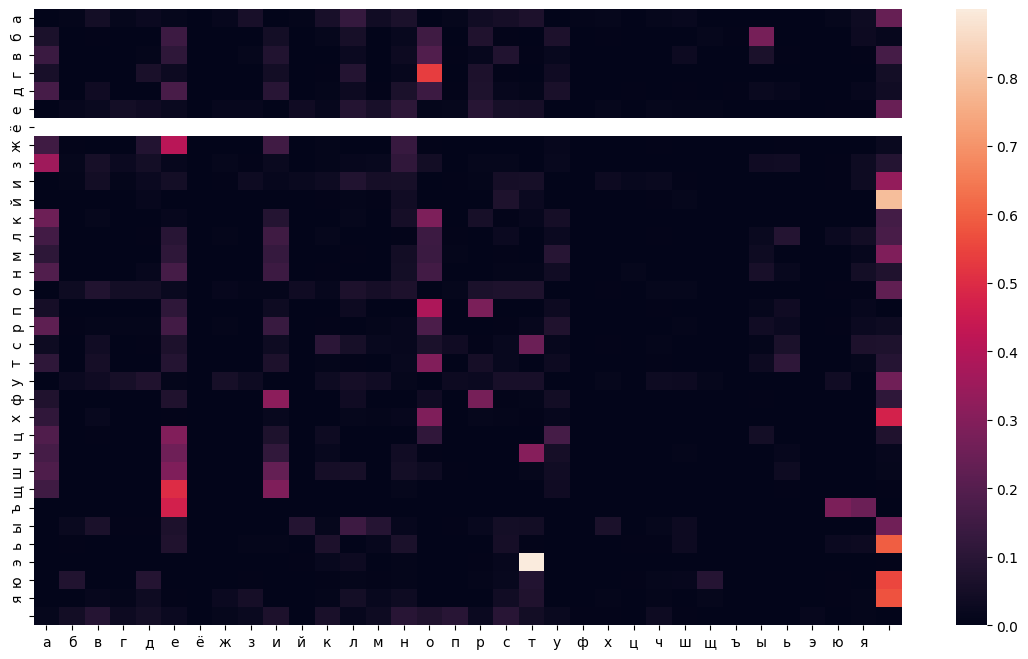

In [14]:
#Визуализируем матрицу переходных вероятностей
plt.figure(figsize=(14,8))
sns.heatmap(df)
plt.show()

**4. Посчитайте вероятность встретить строку из четырёх символов, которая начинается на букву «П» и заканчивается на букву «Р».**

In [15]:
start = POS['п']
end = POS['р']
prior = 1. / len(rus_letters)
sum_prob = 0

for c1 in rus_letters:
    for c2 in rus_letters:
        proba = prior * probabilities[start, POS[c1]] * \
                        probabilities[POS[c1], POS[c2]] * \
                        probabilities[POS[c2], end]

        if proba > 0:
            sum_prob += proba
            print(''.join(['п', c1, c2, 'р']), proba)

print(sum_prob)

паар 1.2483021244621608e-08
пабр 1.0155553856672825e-06
павр 1.15917977686471e-06
пагр 1.2848114697473956e-06
падр 2.942105165838902e-06
паер 1.9503146628298786e-06
пажр 7.311949848239609e-09
пазр 1.2095790878783555e-06
паир 2.547790864803073e-08
пайр 2.7599678947720997e-08
пакр 4.840852058790128e-06
палр 3.3611556905914123e-09
памр 1.0930948458598652e-07
панр 1.161326477180596e-07
паор 4.339681014540716e-08
папр 5.626388035700382e-06
парр 2.870279020272537e-08
паср 5.043304580053417e-07
патр 5.531903526415092e-06
паур 6.923602698965342e-08
пафр 3.17685218286211e-06
пахр 2.440818119506081e-07
пачр 2.6506060145138035e-08
пашр 5.266004634220631e-09
пащр 4.5451641687422465e-09
паэр 3.402682747656317e-10
паюр 1.6147067665876867e-07
паяр 1.4938299828069804e-07
па р 9.18959568553839e-06
пвар 2.806393138584855e-09
пвбр 1.5943951085774744e-11
пввр 8.160012706997085e-12
пвгр 3.321084346893555e-11
пвдр 2.685575343020761e-10
пвер 5.0598785244545456e-09
пвжр 3.909391636356634e-15
пвзр 8.4859471992

**5. Используя матрицу переходных вероятностей, сгенерируйте слово, начинающееся с буквы «Б» длиной восемь символов.**

In [32]:
s = []
start = 'б'
s.append(start)
length = 7

for i in range(length):
    index = POS[s[i]]
    next_char = np.random.choice(list(rus_letters), p=probabilities[index])
    s.append(next_char)

print (''.join(s))

бымасучт


**6. Выберите ряд из предыдущих домашних заданий по временным рядам и оцените его через HMM.**

In [33]:
#Возьмем следующий временной ряд
robberies_in_boston = pd.read_csv("/content/monthly-boston-armed-robberies-j.csv")
all_series = {"Monthly Boston armed robberies": robberies_in_boston["Count"]}

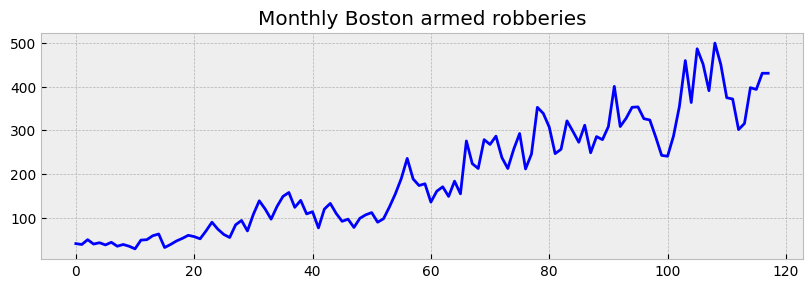

In [34]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

In [35]:
robberies_in_boston.head()

,Month,Count
0,1966-01,41
1,1966-02,39
2,1966-03,50
3,1966-04,40
4,1966-05,43


In [36]:
robberies_in_boston = robberies_in_boston['Count'].values.reshape(-1, 1)
robberies_in_boston[:10]

array([[41],
       [39],
       [50],
       [40],
       [43],
       [38],
       [44],
       [35],
       [39],
       [35]])

In [37]:
from hmmlearn.hmm import GaussianHMM

In [38]:
for n in range(1, 20):
    model = GaussianHMM(n_components=n,
                        covariance_type="diag",
                        n_iter=1000,
                        random_state=42)
    model.fit(robberies_in_boston)
    print (n, model.score(robberies_in_boston))

1 -739.512376545524
2 -651.0127700651242
3 -652.7462110696908
4 -600.4060630985665
5 -631.7065939236336
6 -603.5344824087548
7 -595.1513927292937


8 -574.5738008192452
9 -599.9255902230392
10 -582.9902997330755
11 -596.4961763807377


12 -572.0749859638863
13 -537.8920418759826
14 -562.0175491396354


15 -535.2029128798127
16 -561.1364167331894


17 -526.4943889952202


18 -551.9342791169413
19 -531.5248517204338


In [39]:
best_model = []
for n in range(1, 20):
    model = GaussianHMM(n_components=n,
                        covariance_type="diag",
                        n_iter=1000,
                        random_state=42)
    model.fit(robberies_in_boston)
    best_model.append(model.score(robberies_in_boston))

print(f'Лучший score {max(best_model)} достигается при n_components={np.argmax(best_model)+1}')

Лучший score -526.4943889952202 достигается при n_components=17


**7. Попробуйте построить через среднее каждой компоненты наивный прогноз ряда.**

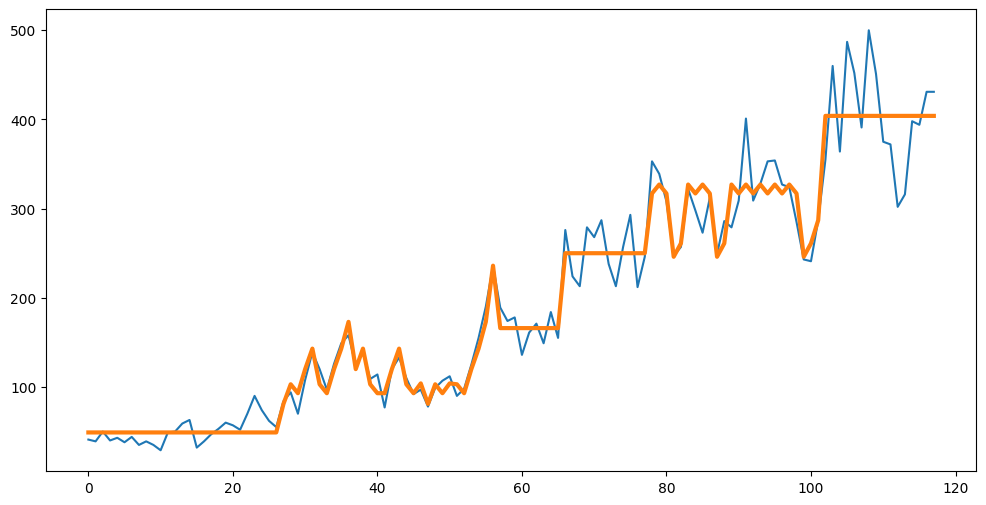

In [40]:
model = GaussianHMM(n_components=17,
                    covariance_type="diag",
                    n_iter=1000,
                    random_state=42)
model.fit(robberies_in_boston)
labels = model.predict(robberies_in_boston)
means = np.zeros_like(robberies_in_boston)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]

plt.figure(figsize=(12, 6))
plt.plot(robberies_in_boston)
plt.plot(means, linewidth=3)

In [41]:
from sklearn.metrics import r2_score
r2_score(y_pred=means, y_true=robberies_in_boston)

0.954385131989945